## 10. Recurrent neural networks

## 10.1 Contextual information (작가의 유년시절)
- 글쓴이는 어렸을 때 OX 퀴즈 시험이 나오면 안도의 한숨을 쉬곤 했다.
- O와 X의 비율을 따져서 X의 개수가 부족하다는 것을 깨달았고, 균형을 맞추기 위해 X로 찍었다.
- 효과 만점이었다.
- 이런 결정을 할 수 있는 사람의 뇌 구조를 뉴럴 네트워크에는 어떻게 적용해 볼 수 있을까?
- 이 질문에 대한 한 가지 대답은 문맥을 사용해서 질문에 대답하도록 학습하는 것이다.
- 문맥 큐는 기계 학습 알고리즘의 성능을 향상시킬 수 있는 중요한 신호이다.
- 예를 들어 영어 문장을 검사하고 각 단어에 품사 태깅을 한다고 가정해보자.
- 가장 순수한 방법은 이웃 단어의 고려 없이 각 단어를 "명사", "형용사" 등으로 개별적으로 분류하는 것이다.
- 하지만 "trying"이라는 단어는 동사로 사용될 수도 있고, 형용사로 사용될 수도 있다.
- 그래서 문맥을 고려하는 것이 중요하다.
- 우리는 문맥 고려를 위해 recurrent neural network라는 아키텍쳐를 연구할 것이다.
- 자연어 대신에 주식 시장 가격과 비슷한 연속 시계열 데이터를 다룰 것이다.
- 이 장의 마지막 부분에서는 시계역 데이터의 패턴을 모델링해서 미래 가치에 대한 예측을 할 수가 있다.

In [5]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
%matplotlib inline

def load_series(filename ,series_dix=1):
    try:
        with open(filename) as csvfile:
            csvreader = csv.reader(csvfile)
            data = [float(row[series_dix]) for row in csvreader if len(row) > 0]
            normalized_data = (data - np.mean(data)) / np.std(data)
        return normalized_data
    except IOError:
        return None

def split_data(data, percent_train=0.80):
    num_rows = len(data)
    train_data, test_data = [], []
    for idx, row in enumerate(data):
        if idx < num_rows * percent_train:
            train_data.append(row)
        else:
            test_data.append(row)
    return train_data, test_data

def plot_results(train_x, predictions, actual, filename):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()
        
class SeriesPredictor:
    
    def __init__(self, input_dim, seq_size, hidden_dim=10):
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        
        self.W_out = tf.Variable(tf.random_normal([hidden_dim, 1]), name='W_out')
        self.b_out = tf.Variable(tf.random_normal([1]), name='b_out')
        self.x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
        self.y = tf.placeholder(tf.float32, [None, seq_size])
        self.cost = tf.reduce_mean(tf.square(self.model() - self.y))
        self.train_op = tf.train.AdamOptimizer().minimize(self.cost)
        self.saver = tf.train.Saver()
        state_init = tf.Variable(tf.zeros([1, 5]))
        self.init_state = tf.tile(state_init, [110, 1])
        
    def model(self):     
        cell = rnn.BasicLSTMCell(self.hidden_dim, reuse=tf.get_variable_scope().reuse)
        outputs, states = tf.nn.dynamic_rnn(cell, self.x, dtype=tf.float32)
        print(outputs)    
        num_examples = tf.shape(self.x)[0]
        W_repeated = tf.tile(tf.expand_dims(self.W_out, 0), [num_examples, 1, 1])
        out = tf.matmul(outputs, W_repeated) + self.b_out
        out = tf.squeeze(out)
        print(out)
        return out
        
    def train(self, train_x, train_y, test_x, test_y):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            sess.run(tf.global_variables_initializer())
            max_patience = 3
            patience = max_patience
            min_test_err = float('inf')
            step = 0
            while patience > 0:
                _, train_err = sess.run([self.train_op, self.cost], feed_dict={self.x: train_x, self.y: train_y})
                if step % 100 == 0:
                    test_err = sess.run(self.cost, feed_dict={self.x: test_x, self.y: test_y})
                    print('step: {}\t\ttrain err: {}\t\ttest err: {}'.format(step, train_err, test_err))
                    if test_err < min_test_err:
                        min_test_err = test_err
                        patience = max_patience
                    else:
                        patience -= 1
                step += 1
            save_path = self.saver.save(sess, "model.ckpt")
            print("Model saved to {}".format(save_path))
        
    def test(self, sess, test_x):
        tf.get_variable_scope().reuse_variables()
        self.saver.restore(sess, "./model.ckpt")
        output = sess.run(self.model(), feed_dict={self.x: test_x})
        return output

Tensor("rnn_1/transpose:0", shape=(?, 5, 100), dtype=float32)
Tensor("Squeeze:0", dtype=float32)
step: 0		train err: 1.14805448055		test err: 0.636205017567
step: 100		train err: 0.064535997808		test err: 0.274572938681
step: 200		train err: 0.0457101538777		test err: 0.249963134527
step: 300		train err: 0.0441470183432		test err: 0.235344842076
step: 400		train err: 0.0431082956493		test err: 0.239214971662
step: 500		train err: 0.0421952866018		test err: 0.255475997925
step: 600		train err: 0.0414061360061		test err: 0.279489040375
Model saved to model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
Tensor("rnn_2/transpose:0", shape=(?, 5, 100), dtype=float32)
Tensor("Squeeze_1:0", dtype=float32)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Tensor("rnn_3/transpose:0", shape=(?, 5, 100), dtype=float32)
Tensor("Squeeze_2:0", dtype=float32)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Tensor("rnn_4/transpose:0", shape=(?, 5, 100), dtype=float32)
Tensor("S

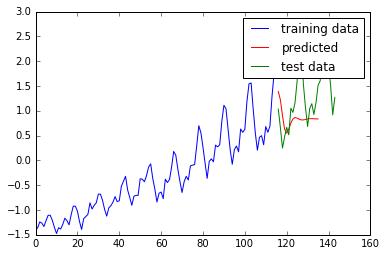

In [6]:
seq_size = 5
predictor = SeriesPredictor(input_dim=1, seq_size=seq_size, hidden_dim = 100)

data = load_series('international-airline-passengers.csv')
train_data, actual_vals = split_data(data)
train_x, train_y = [], []
for i in range(len(train_data) - seq_size - 1):
    train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
    train_y.append(train_data[i+1:i+seq_size+1])
    
test_x, test_y = [], []
for i in range(len(actual_vals) - seq_size - 1):
    test_x.append(np.expand_dims(actual_vals[i:i+seq_size], axis=1).tolist())
    test_y.append(actual_vals[i+1:i+seq_size+1])

predictor.train(train_x, train_y, test_x, test_y)

with tf.Session() as sess:
    prev_seq = train_x[-1]
    predicted_vals = []
    for i in range(20):
        next_seq = predictor.test(sess, [prev_seq])
        predicted_vals.append(next_seq[-1])
        prev_seq = np.vstack((prev_seq[1:], next_seq[-1]))
    plot_results(train_data, predicted_vals, actual_vals, 'hallucinations.png')